In [1]:
# Our custom module
from nn import DeepQNetwork
from custom_parking_env import ParkingWithObstacles
from relay_mem import ReplayMemory,Transition

# python module
import gymnasium as gym
import torch
import torch.optim as optim
import numpy as np
import random
import matplotlib.pyplot as plt
import torch.nn as nn
from IPython import display

# combine observation
def process_observation(observation):
    # observation_vector = np.concatenate((
    #     observation["observation"],
    #     observation["achieved_goal"],
    #     observation["desired_goal"]
    # ))
    return observation["observation"]

# interactive mode
plt.ion()

# Create the original environment and wrap it into an environment with obstacles
env_origin = gym.make("parking-v0")#,render_mode="human")
env = ParkingWithObstacles(env_origin)
env.define_spaces()

# terminated The episode is over if the ego vehicle crashed or the goal is reached or time is over.
terminated = False

# The episode is truncated if the time is over.
truncated = False

# Print the number of states and actions
print(f"Observation Space: {env.observation_space}")
# observation["observation"] Box(-inf, inf, (6,), float64)
# observation["achieved_goal"] Box(-inf, inf, (6,), float64)
# observation["desired_goal"] Box(-inf, inf, (6,), float64)

print(f"Action Space: {env.action_space}")
# Discrete(5)


# Get the number of state observations
state, info = env.reset()



Observation Space: Dict('achieved_goal': Box(-inf, inf, (6,), float64), 'desired_goal': Box(-inf, inf, (6,), float64), 'observation': Box(-inf, inf, (6,), float64))
Action Space: Box(-1.0, 1.0, (2,), float32)


In [2]:
# if GPU is to be used
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS")
else:
    device = torch.device("cpu")
    print("Using CPU")
    
candidate_actions = []

for steering in np.linspace(-0.5, 0.5, 4):
        for acceleration in np.linspace(0.8, 0.4, 11):
            candidate_actions.append(torch.tensor([acceleration, steering],device=torch.device("cpu")))
            
# print(candidate_actions)

# Get number of actions from gym action space
n_actions = len(candidate_actions)
n_observations = len(process_observation(state))  # 6 (observation)

Using CPU


In [3]:


# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 64
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
# EPS_DECAY = 1000
# TAU = 0.005
TARGET_UPDATE = 10
LR = 0.0001
EPISODES = 300

policy_net = DeepQNetwork(n_observations, n_actions).to(device)
target_net = DeepQNetwork(n_observations, n_actions).to(device)
# init weight (by policy net)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(20000)

# Training loop
num_episodes = EPISODES
epsilon_decay_rate = -np.log(EPS_END / EPS_START) / num_episodes
epsilon_values = []
episode_rewards = []  # Store total rewards per episode
losses = []
episode_durations = []

In [4]:
steps_done = 0
def select_action(state , i_episode):
    global steps_done
    sample = random.random()
    epsilon_threshold = EPS_START * np.exp(-epsilon_decay_rate * i_episode)
    epsilon_values.append(epsilon_threshold)
    steps_done += 1
    # exploitation
    if sample > epsilon_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            # tensor 1x1 , return action index
            return policy_net(state).max(1).indices.view(1, 1)
    # exploration
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)

def optimize_policy_net():
    # Check if enough transitions are available in replay_buffer
    if len(memory) < BATCH_SIZE:
        return

    # Sample a batch of transitions
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(
                        tuple(map(lambda s: s is not None,
                        batch.next_state)), 
                        device=device, 
                        dtype=torch.bool)
    
    non_final_next_states = []
    for s in batch.next_state:
        if s is not None:  # Check if s is not None
            non_final_next_states.append(s)  # Add elements that meet the condition to the list
    
    if len(non_final_next_states) == 0 :
        # Use a placeholder tensor with the appropriate shape
        # Assuming the state has a known shape, e.g., (batch_size, state_dim)
        non_final_next_states = tuple(torch.zeros(torch.Size([1, 6]), device=device).unsqueeze(0))
        print("none occur")

    # RuntimeError: torch.cat(): expected a non-empty list of Tensors
    non_final_next_states = torch.cat(non_final_next_states)
    
    # Concatenate batch tensors
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)

    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the policy network
    optimizer.zero_grad()
    loss.backward()

    # In-place gradient clipping
    # for param in policy_net.parameters():
    #     param.grad.data.clamp_(-1, 1)
    torch.nn.utils.clip_grad_norm_(policy_net.parameters(), max_norm=1.0)
    optimizer.step()

    # Track the loss for plotting
    losses.append(loss.item())
    print(f"Loss: {loss.item()}")

def moving_average(data, window_size=50):
    # convolution
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

def plot_training_durations():
    # Create a new figure for the plot
    plt.clf()

    # Convert episode rewards to tensors
    rewards_t = torch.tensor(episode_rewards, dtype=torch.float, device=device)

    # Plot rewards per episode
    plt.subplot(3, 1, 1)
    plt.title('Training Progress (Per Episode)')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    
    # Move GPU tensor back to CPU and convert it to NumPy
    plt.plot(rewards_t.cpu().numpy(), label="Total Reward")
    
    # Add smoothed rewards
    if len(episode_rewards) >= 50:  # Ensure enough data for smoothing
        smoothed_rewards = moving_average(episode_rewards, window_size=50)
        plt.plot(range(len(smoothed_rewards)), smoothed_rewards, label="Smoothed Rewards", color='orange')
    plt.legend()

    # Plot losses per step
    plt.subplot(3, 1, 2)
    plt.title('Loss (Per Step)')
    plt.xlabel('Training Step')
    plt.ylabel('Loss')
    plt.plot(losses, label="Loss", color='red')
    plt.legend()

    # Plot epsilon decay per step
    plt.subplot(3, 1, 3)
    plt.title('Epsilon Decay (Per Step)')
    plt.xlabel('Training Step')
    plt.ylabel('Epsilon')
    plt.plot(epsilon_values, label="Epsilon Decay", color='blue')
    plt.legend()

    # Adjust layout to increase space between plots
    plt.subplots_adjust(hspace=0.5)  # Adjust spacing between rows

    # Pause briefly to update the plot
    plt.pause(0.01)

    # Clear the current output and display the updated plot
    display.display(plt.gcf())

Done: True, Truncated: False
{'speed': 3.9141925925925936, 'crashed': True, 'action': array([ 0.4, -0.5]), 'is_success': False}
Episode 1 finished after 9 steps


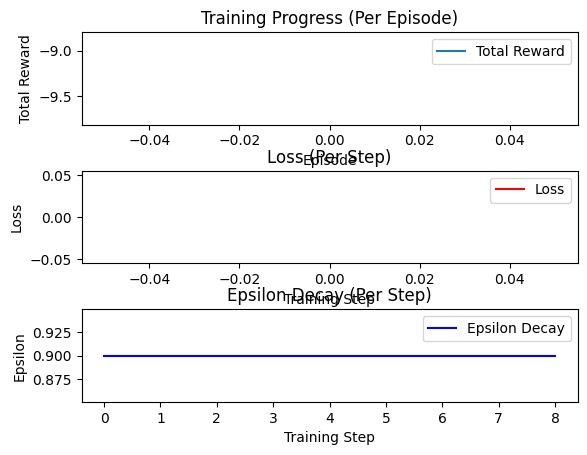

<Figure size 640x480 with 0 Axes>

Episode 1/300, Total Reward: -9.305887070417423
Done: True, Truncated: False
{'speed': 4.679999999999999, 'crashed': True, 'action': array([0.44, 0.5 ]), 'is_success': False}
Episode 2 finished after 8 steps
Episode 2/300, Total Reward: -8.986277185348701
Loss: 0.22958652541912047
Loss: 4.2852845098312216
Loss: 0.31128654563716746
Loss: 0.22726373046319445
Loss: 0.1893063231130993
Loss: 0.14768464326186315
Loss: 0.24231971695541946
Loss: 0.09318442831495725
Loss: 0.06536724541055691
Loss: 0.08260994346343291
Loss: 0.040973272611527195
Loss: 0.06298053780342071
Loss: 0.034231786897627466
Loss: 0.04115219472855054
Loss: 0.014892603456684693
Loss: 0.034085675925905175
Loss: 0.019927595103006342
Loss: 0.02814341633219842
Loss: 0.025534437731619758
Loss: 0.03313471025307934
Loss: 0.06520921671341551
Loss: 0.023308561252136366
Loss: 0.07285291536509911
Loss: 0.05241531607497975
Loss: 0.11271668583604519
Loss: 0.06297446488356312
Loss: 0.07802522281383541
Loss: 0.02455863338280112
Loss: 0.005

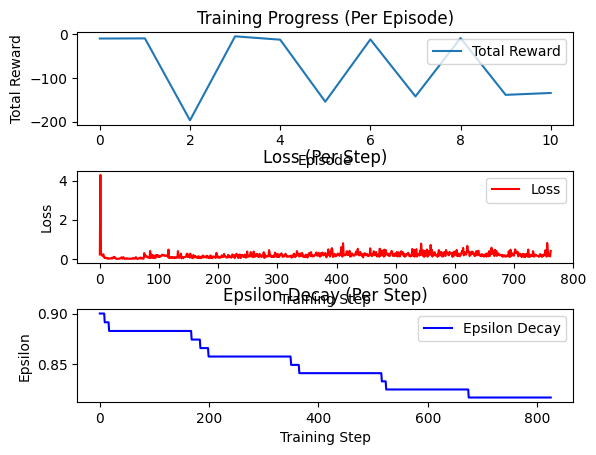

<Figure size 640x480 with 0 Axes>

Episode 11/300, Total Reward: -134.19155285992986
Loss: 0.1974086872268505
Loss: 0.13020890288525627
Loss: 0.31135141356398455
Loss: 0.13130185491645277
Loss: 0.4038324683560565
Loss: 0.2871756113300008
Loss: 0.413301750517583
Loss: 0.14263839334267298
Loss: 0.25195803894383445
Loss: 0.18187765371190256
Loss: 0.23685675712852464
Loss: 0.09372136217665765
Loss: 0.3284359140965268
Loss: 0.08333930078256192
Loss: 0.20702906391782022
Loss: 0.1753786829222733
Loss: 0.32695134586902563
Loss: 0.14651458553173827
Loss: 0.2013750179525664
Loss: 0.23297216960346154
Loss: 0.20440882761528495
Loss: 0.1515622579428656
Loss: 0.18635771344018395
Loss: 0.19297166308185348
Loss: 0.26682258311569074
Loss: 0.1527249596905166
Loss: 0.16643787678339494
Loss: 0.3457534611163598
Loss: 0.1711337827582789
Loss: 0.15841849018069834
Loss: 0.21992295581503957
Loss: 0.2370828498559744
Loss: 0.332417160820652
Loss: 0.25942928272224625
Loss: 0.2394601528449596
Loss: 0.320673384929521
Loss: 0.18623344336645398
Loss: 

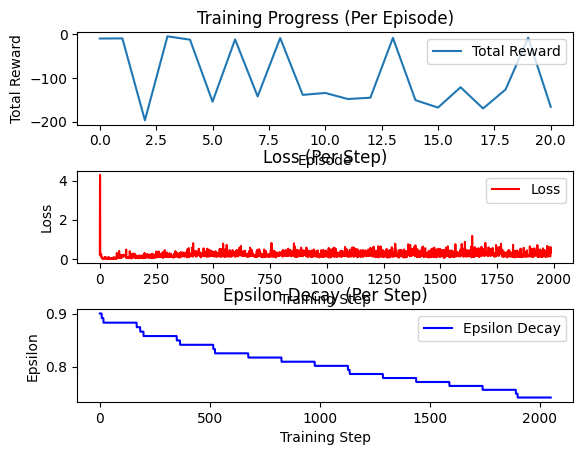

<Figure size 640x480 with 0 Axes>

Episode 21/300, Total Reward: -165.93202275445142
Loss: 0.3098464945158299
Loss: 0.20754080338246303
Loss: 0.5650053558198249
Loss: 0.2616981083984574
Loss: 0.42121308320035805
Loss: 0.22976643902052304
Loss: 0.23763507423542146
Loss: 0.24018697122464258
Loss: 0.6169638921385212
Loss: 0.5848448981190192
Loss: 0.38498128559688705
Loss: 0.2819433956446872
Loss: 0.3732068692395282
Loss: 0.24064300951711193
Loss: 0.30938798579606464
Done: True, Truncated: False
{'speed': 7.2128, 'crashed': True, 'action': array([ 0.6, -0.5]), 'is_success': False}
Episode 22 finished after 15 steps
Episode 22/300, Total Reward: -10.334972021061024
Loss: 0.19720991329947837
Loss: 0.09611317669712685
Loss: 0.34530196061996554
Loss: 0.16569931577665034
Loss: 0.22634273915089584
Loss: 0.10437955355143394
Loss: 0.2994020724065012
Loss: 0.7981602453256693
Loss: 0.3000891251516801
Loss: 0.33577505439624133
Loss: 0.7119492561869916
Loss: 0.5942593093063399
Loss: 1.003970002355437
Loss: 0.5806620548992043
Loss: 0.43

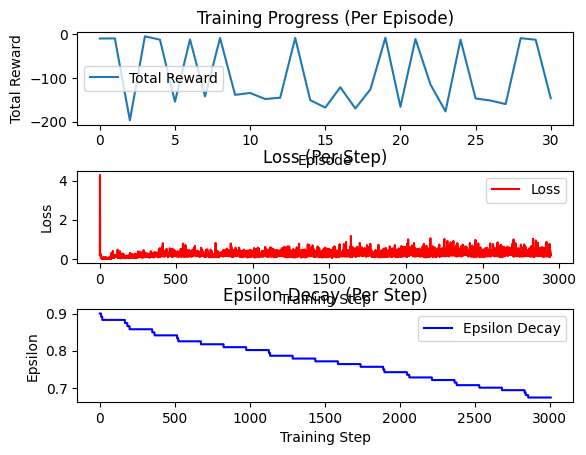

<Figure size 640x480 with 0 Axes>

Episode 31/300, Total Reward: -146.14112322825514
Loss: 0.3600169177148378
Loss: 0.15173404380946065
Loss: 1.2139437899376164
Loss: 0.2512336057661871
Loss: 0.21043715937892324
Loss: 1.232873706328809
Loss: 0.4188437568604786
Loss: 0.29976566350850115
Loss: 0.14343030213763028
Loss: 0.442895505014446
Loss: 0.15021010797503323
Loss: 0.10619299071752492
Loss: 0.4774423574236728
Loss: 0.2362877210749377
Loss: 0.2644848804611336
Loss: 0.22297459048350254
Loss: 0.20578184419786466
Loss: 0.5125007802921518
Loss: 0.6286834311117434
Loss: 0.19005734978857194
Loss: 0.21905639723984344
Loss: 0.09934520945767183
Loss: 0.4232170712265283
Loss: 0.1243643770249055
Loss: 0.5226316833943642
Loss: 0.21663748789433993
Loss: 0.3291728512444455
Loss: 0.15664990781153898
Loss: 0.31581484108509916
Loss: 0.3422882435396182
Loss: 0.19510115198379718
Loss: 0.16638556505715296
Loss: 0.19871877756952477
Loss: 0.5751235868832982
Loss: 0.1803038561615692
Loss: 0.12118892621755879
Loss: 0.21535986346094546
Loss: 0.

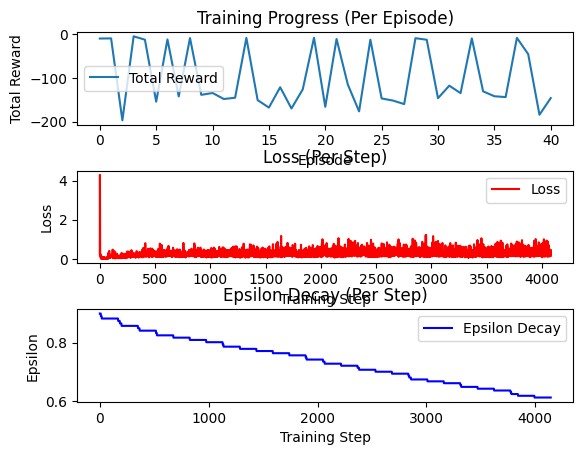

<Figure size 640x480 with 0 Axes>

Episode 41/300, Total Reward: -145.90698773458345
Loss: 0.3819495125517488
Loss: 0.2225819302385019
Loss: 0.19677127570971756
Loss: 0.14619809095023092
Loss: 0.3776558353650373
Loss: 0.5383463226705939
Loss: 0.25601897728799994
Loss: 0.18511825425195783
Done: True, Truncated: False
{'speed': 4.815999999999999, 'crashed': True, 'action': array([ 0.48, -0.5 ]), 'is_success': False}
Episode 42 finished after 8 steps
Episode 42/300, Total Reward: -8.349835682965427
Loss: 0.20448664317269236
Loss: 0.16836613940414372
Loss: 0.6712306355718415
Loss: 0.4657571796692053
Loss: 0.5423677861447675
Loss: 0.1666466232585268
Loss: 0.5209099210918288
Loss: 0.2013352869465761
Loss: 0.32468778206252485
Loss: 0.20875399084249407
Loss: 0.7042864182264075
Loss: 0.13164681451413426
Loss: 0.6557007762262959
Loss: 0.12279372719369695
Done: True, Truncated: False
{'speed': 8.33777777777778, 'crashed': True, 'action': array([0.8       , 0.16666667]), 'is_success': False}
Episode 43 finished after 14 steps
Episo

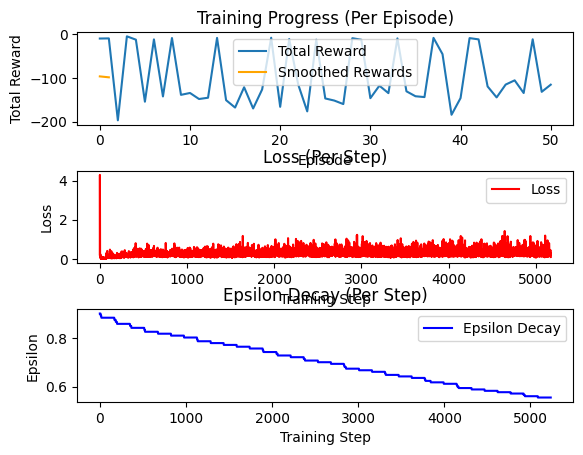

<Figure size 640x480 with 0 Axes>

Episode 51/300, Total Reward: -115.16836324372609
Loss: 0.10035709643233415
Loss: 0.11780370873168294
Loss: 0.43005179073531097
Loss: 0.1702426898425126
Loss: 0.2156804223233687
Loss: 0.41138441869015474
Loss: 0.23672229815424295
Loss: 0.5619698413996518
Loss: 0.20183799313866452
Loss: 0.23553794366455388
Loss: 0.40720504977400285
Loss: 0.17103455414246307
Loss: 1.085755273338855
Loss: 0.16759668765880634
Loss: 0.2094122375534858
Loss: 0.18418575985849553
Loss: 0.1848617847876019
Loss: 0.1829968200111195
Loss: 0.2655546806773619
Loss: 0.18609666709486156
Loss: 0.11649089729789658
Loss: 0.3791655062691063
Loss: 0.8024797478809045
Loss: 0.3341204115917965
Loss: 0.33604826335395205
Loss: 0.7760945034301286
Loss: 0.40756126577667096
Loss: 0.4795450550125276
Loss: 0.2098363930004259
Loss: 0.1197576017180787
Loss: 0.29116617396670347
Loss: 0.1122546961975066
Loss: 0.5238854198319253
Loss: 0.425161703885499
Loss: 0.18148566069933503
Loss: 0.12672743439743991
Loss: 0.5801369253586223
Loss: 0.1

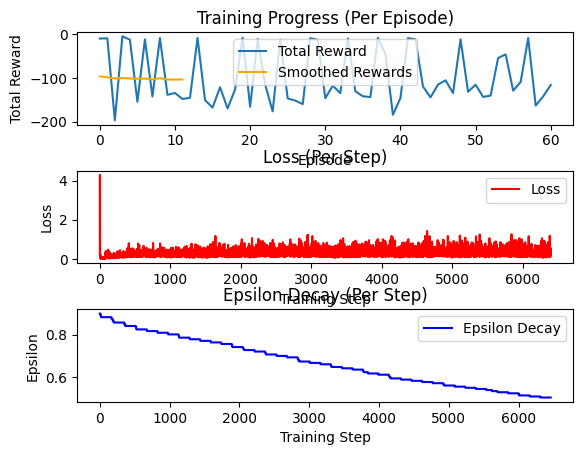

<Figure size 640x480 with 0 Axes>

Episode 61/300, Total Reward: -115.93191252185888
Loss: 0.1277768956071494
Loss: 0.5331347284354129
Loss: 0.2789421480629358
Loss: 0.13721906923480273
Loss: 0.18809539821672971
Loss: 0.847524926074601
Loss: 0.167807056458407
Loss: 0.22917077913507009
Loss: 0.877513272349488
Loss: 0.3816631191589262
Loss: 0.16109445934774852
Loss: 0.1935619587424774
Loss: 0.30240077561465406
Loss: 0.18097338806305646
Loss: 0.24641120106529044
Loss: 0.17914155469610227
Loss: 0.6577021910768368
Loss: 0.2413083000726911
Loss: 0.3052331157096433
Loss: 0.48076864954299153
Loss: 0.2720097285351879
Loss: 0.17673673236671453
Loss: 0.1260347331999457
Loss: 0.5343683784143752
Loss: 0.31160696535018767
Loss: 0.7341901336237544
Loss: 0.5406728600186941
Loss: 0.16737935847942165
Loss: 0.9810928768976462
Loss: 0.14496377835089225
Loss: 0.47466568608376386
Loss: 0.1426209734603137
Loss: 0.8368027788945852
Loss: 0.9129331553638911
Loss: 0.28413362243365103
Loss: 0.2713899135802839
Loss: 0.24154026514447002
Loss: 0.2463

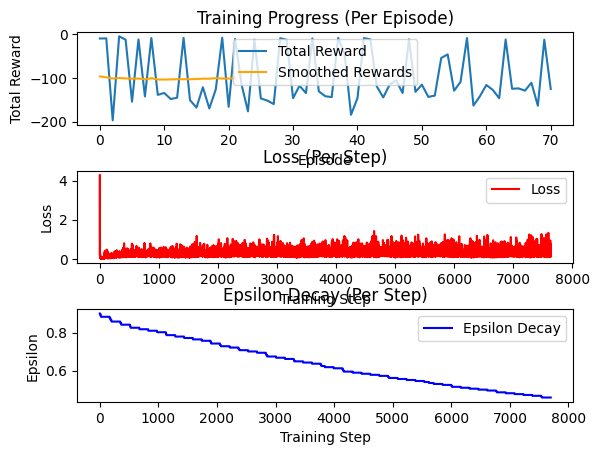

<Figure size 640x480 with 0 Axes>

Episode 71/300, Total Reward: -124.99526359023727
Loss: 0.3220599309334063
Loss: 0.34402355705284404
Loss: 1.009299821329208
Loss: 0.4373332878932821
Loss: 0.2670299053257526
Loss: 0.36923627697994454
Loss: 0.3134591494984682
Loss: 0.41261161329756085
Loss: 0.6635743531003166
Loss: 0.5964299955893956
Loss: 0.6594645629254964
Loss: 0.1534973244684068
Loss: 0.725941905486217
Loss: 0.44591809119811626
Loss: 0.1951668710256856
Loss: 0.22432514928795477
Loss: 0.1276813307317437
Loss: 0.19405631748021018
Loss: 0.1425946093933469
Loss: 0.21759416988610272
Loss: 0.24499969554263132
Loss: 0.4565003886640464
Loss: 0.18024568912935227
Loss: 0.6845419442952467
Loss: 0.2749443483520927
Loss: 1.4640075710602491
Loss: 0.20300487196287428
Loss: 0.18080529575971258
Loss: 0.9308026736480806
Loss: 0.1697307858794413
Loss: 0.14614264345719377
Loss: 0.41052405541114495
Loss: 0.6413985571181471
Loss: 0.5847253867405084
Loss: 0.2094764882489307
Loss: 0.6001392437446919
Loss: 0.24763637975028788
Loss: 0.19858

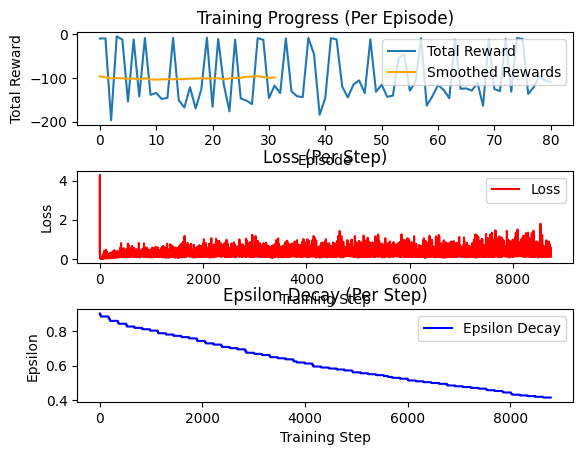

<Figure size 640x480 with 0 Axes>

Episode 81/300, Total Reward: -108.49241844906317
Loss: 0.1297492589806163
Loss: 0.5475221210857169
Loss: 0.28331861869845554
Loss: 0.12188779062057559
Loss: 0.25066691333793245
Loss: 0.13826666152466652
Loss: 1.15776248436176
Loss: 0.48102152738582865
Loss: 0.6710125018337142
Loss: 0.17778952801945547
Loss: 0.42305849427461006
Loss: 0.14966343649922478
Loss: 0.27489720999324574
Loss: 0.2626759804008784
Loss: 0.25246374093275703
Loss: 0.14788840577901846
Loss: 0.22615775180784314
Loss: 0.3826502291485109
Loss: 0.23408901651645003
Loss: 0.6804918794651946
Loss: 0.2434095793233591
Loss: 1.2407936536795052
Loss: 0.2263818581125317
Loss: 0.18693423442499962
Loss: 0.9668135755400193
Loss: 0.1717672295273419
Loss: 0.26885680865879635
Loss: 0.20578537032605282
Loss: 0.8744280240161699
Loss: 0.16016411370566885
Loss: 0.34580628641690153
Loss: 0.13305141387619762
Loss: 0.21814572991638226
Loss: 0.30711768606068063
Loss: 0.47337601648971206
Loss: 1.0089517390466878
Loss: 0.17825508771980889
Loss

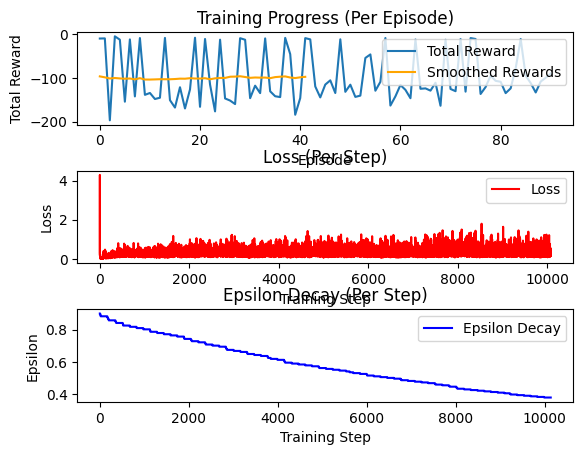

<Figure size 640x480 with 0 Axes>

Episode 91/300, Total Reward: -89.6892519081122
Loss: 0.1818832219562524
Loss: 0.45999525579177136
Loss: 0.325691195018153
Loss: 0.7896858993501045
Loss: 0.23276435741424406
Loss: 0.5438900566065676
Loss: 0.18975922361149367
Loss: 0.19767866795322056
Loss: 0.127331798350949
Loss: 0.17329955817542872
Loss: 0.1399236146503623
Loss: 0.18868646385001592
Loss: 0.5054549917113528
Loss: 0.12733415457259417
Loss: 0.2442281362823796
Loss: 0.25074666229133946
Loss: 0.22019409398392814
Loss: 0.1533383198659852
Loss: 0.22053522439935924
Loss: 0.17268566946102817
Loss: 0.20436128608122603
Loss: 0.25145147313772875
Loss: 0.2574118470961135
Loss: 0.19895745670846338
Loss: 0.16944078536380944
Loss: 0.18652633531531063
Loss: 0.7774044853401398
Loss: 0.16297121826910357
Loss: 0.2525126015098521
Loss: 0.1430090606384426
Loss: 0.21928487756123105
Loss: 0.8191254833208349
Loss: 0.49280404463259997
Loss: 1.6132089870509296
Loss: 0.48273530034015455
Loss: 0.5912435842445058
Loss: 0.5492910948802591
Loss: 0.2

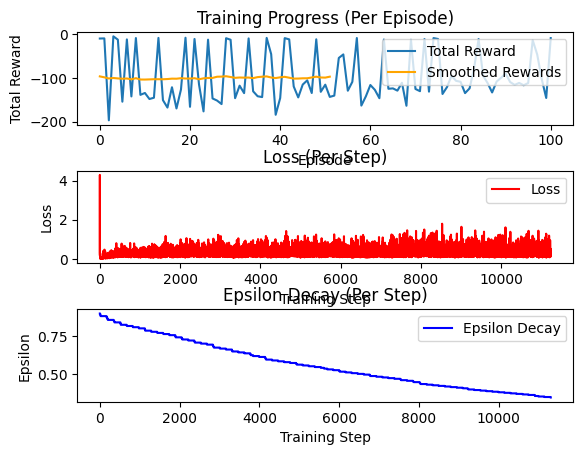

<Figure size 640x480 with 0 Axes>

Episode 101/300, Total Reward: -8.29367417778883
Loss: 0.471806674973026
Loss: 0.18372936513662508
Loss: 0.7248997664327737
Loss: 0.17092906229604454
Loss: 0.7876577862674441
Loss: 0.6273732755262524
Loss: 0.6737373061540314
Loss: 0.20540962037638547
Loss: 0.8344062980800739
Loss: 0.6647035114247386
Loss: 0.9568081150860236
Loss: 0.126597119409144
Loss: 0.2508983144091789
Loss: 0.8672156418961459
Loss: 0.19089177540338753
Loss: 0.28287695798835805
Done: True, Truncated: False
{'speed': 9.519999999999996, 'crashed': True, 'action': array([ 0.6, -0.5]), 'is_success': False}
Episode 102 finished after 16 steps
Episode 102/300, Total Reward: -11.494065764026415
Loss: 0.2601822940685727
Loss: 0.12214593548261046
Loss: 0.22549271514255936
Loss: 0.45650227863609627
Loss: 0.16399850123027312
Loss: 0.178976661500392
Loss: 1.0685295970557653
Loss: 0.22302760447352732
Loss: 0.18327262215536277
Loss: 0.14982238823042
Loss: 0.17302400833920917
Loss: 0.1639821976279756
Loss: 0.26853055658005903
Loss

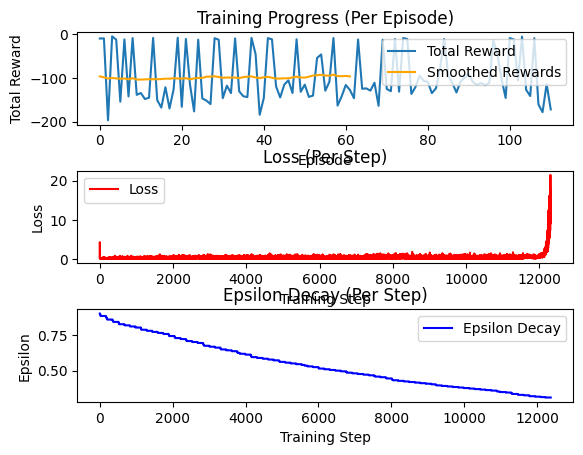

<Figure size 640x480 with 0 Axes>

Episode 111/300, Total Reward: -171.80435915357353
Loss: 19.661833413726335
Loss: 24.474528208555014
Loss: 20.478275828517944
Loss: 21.407277684430426
Loss: 14.386997540720152
Loss: 13.624813996299785
Loss: 15.521615430780416
Loss: 10.483553538007044
Loss: 12.104748149328968
Loss: 14.18391995685549
Loss: 12.437681572479953
Loss: 32.97972089771959
Loss: 12.305419391408751
Loss: 14.027106869443433
Loss: 13.362866876153909
Loss: 11.113667222497131
Loss: 17.99120552539354
Loss: 15.930681966267016
Loss: 14.913665510549603
Loss: 15.778656702414413
Loss: 15.871565386346125
Loss: 24.80837292413056
Loss: 26.886698361942933
Loss: 14.63698112539234
Loss: 10.320818087091768
Loss: 26.74733756958366
Loss: 11.96657044483166
Loss: 15.640403530522482
Loss: 15.615869019662327
Loss: 15.772149706657235
Loss: 14.290599348729481
Loss: 29.90389742561165
Loss: 13.739900756545023
Loss: 14.860732418012102
Loss: 13.17152309514061
Loss: 14.948420336799346
Loss: 12.754114191863696
Loss: 14.501871393151092
Loss: 13

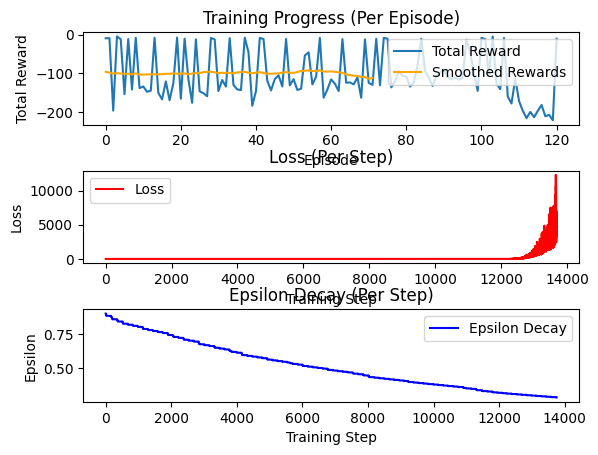

<Figure size 640x480 with 0 Axes>

Episode 121/300, Total Reward: -10.356943467068625
Loss: 3000.369742866258
Loss: 4282.768755980728
Loss: 2552.672391512419
Loss: 5526.999516580898
Loss: 3073.739000516807
Loss: 6986.259016883826
Loss: 2735.04437243591
Loss: 8469.08376232496
Loss: 5996.142538194254
Loss: 6600.788675125573
Loss: 3877.07116940865
Loss: 4538.813847173009
Loss: 6515.971459125478
Loss: 2926.8613266308007
Done: True, Truncated: False
{'speed': 8.880000000000003, 'crashed': True, 'action': array([ 0.64, -0.5 ]), 'is_success': False}
Episode 122 finished after 14 steps
Episode 122/300, Total Reward: -11.577047216802239
Loss: 2194.1600412393204
Loss: 8206.564154099266
Loss: 2797.074913451524
Loss: 3437.4785416054697
Loss: 2648.40887731576
Loss: 4378.159220189795
Loss: 8089.186753884106
Loss: 2835.7870734596836
Loss: 6999.550139596472
Loss: 8224.223288955498
Loss: 6889.43351528556
Loss: 5472.203325618886
Loss: 2778.0315392862985
Loss: 3039.1047494500012
Loss: 3512.3631299195204
Loss: 6543.766128049328
Loss: 3273.

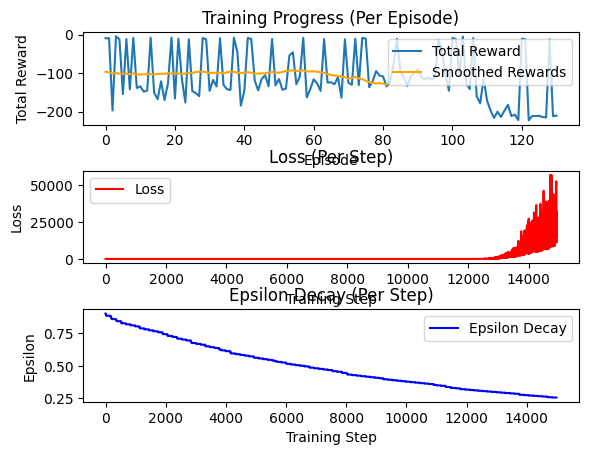

<Figure size 640x480 with 0 Axes>

Episode 131/300, Total Reward: -210.23206974257482
Loss: 27670.640248825875
Loss: 29592.097105396802
Loss: 15989.965745183374
Loss: 13141.449616416347
Loss: 18153.483351127914
Loss: 13943.814580152475
Loss: 17569.74891745016
Loss: 41967.86924668926
Loss: 16059.045423930957
Loss: 15147.252532782792
Loss: 18520.08204637112
Loss: 14140.911548679083
Loss: 13882.8601070425
Loss: 15186.094196823831
Loss: 14340.492615280378
Loss: 12756.783276480519
Loss: 15537.55720486647
Loss: 9364.56332916325
Loss: 12427.931492755364
Loss: 22395.631059139825
Loss: 45236.4477538161
Loss: 13099.059648014012
Loss: 16132.064491758027
Loss: 22890.28987062537
Loss: 19599.16126712248
Loss: 15072.73499869374
Loss: 47097.51028947941
Loss: 13283.054472194075
Loss: 13405.278028166766
Loss: 12595.138585617635
Loss: 29176.16153918802
Loss: 14431.815057165562
Loss: 12678.199017833598
Loss: 13595.9612533504
Loss: 12252.520815335543
Loss: 25396.516682296307
Loss: 10277.54135572187
Loss: 39149.89963955867
Loss: 9109.1597504

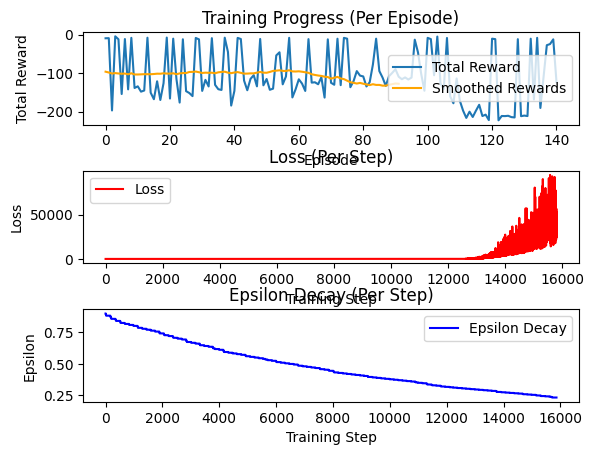

<Figure size 640x480 with 0 Axes>

Episode 141/300, Total Reward: -122.7196570685395
Loss: 43159.06027692102
Loss: 19589.171415843506
Loss: 22348.974819941814
Loss: 28510.10959277524
Loss: 52418.894607136026
Loss: 23969.29065115642
Loss: 29014.402811434975
Loss: 24963.91702697941
Loss: 49678.04989659688
Loss: 72372.04215815023
Loss: 23302.291288469303
Loss: 27253.69755001001
Loss: 31414.145796427103
Loss: 23960.68932528213
Loss: 29621.44038492737
Loss: 22454.23953079168
Loss: 27256.507789839645
Loss: 54844.71854050776
Loss: 28178.601461748007
Loss: 24215.982834507144
Loss: 50490.940149255955
Loss: 25247.61080449722
Loss: 32243.89711584397
Loss: 26210.634543679316
Loss: 41935.40943620985
Loss: 27249.128598166593
Loss: 45675.173994554716
Loss: 24084.439392672655
Loss: 45342.73341634111
Loss: 94839.90956371653
Loss: 30303.051472525323
Loss: 78046.00860082317
Loss: 28883.32822919577
Loss: 26898.87060322091
Loss: 35330.90074294275
Loss: 55336.12546611084
Loss: 51267.60544715333
Loss: 49549.28415088248
Loss: 30245.37152272445

In [ ]:
def update_target_network(t):
    if t % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

for i_episode in range(num_episodes):
    # Initialize the environment and get the initial state
    observation, info = env.reset()
    observation_vector = process_observation(observation)
    observation_tensor = torch.tensor(observation_vector, dtype=torch.float32, device=device).unsqueeze(0)

    total_reward = 0  # Track the total reward for this episode
    t = 0  # Add a time step counter for the current episode
    
    while(True):
        # Select an action
        action_index = select_action(observation_tensor, i_episode)
        action = candidate_actions[action_index.item()]

        # Perform the action and observe the result
        observation, reward, done, truncated, info = env.step(action.numpy())
        reward = torch.tensor([reward], device=device)
        total_reward += reward.item()

        # Process the next state
        if (not done) and (not truncated): # not done or not truncated
            observation_vector = process_observation(observation)
            next_observation_tensor = torch.tensor(observation_vector, dtype=torch.float32, device=device).unsqueeze(0)
        else: # done or truncated
            next_observation_tensor = None

        # Store the experience in memory, including if the episode was truncated
        memory.push(observation_tensor, action_index, next_observation_tensor, reward)

        # Update the current state
        observation_tensor = next_observation_tensor

        # Optimize the policy network
        optimize_policy_net()

        # Update the target network
        update_target_network(t)

        # If the episode is done, record the result and break the loop
        if done or truncated:
            print(f"Done: {done}, Truncated: {truncated}")
            print(info)
            episode_durations.append(t + 1)
            episode_rewards.append(total_reward)

            if truncated:
                print(f"Episode {i_episode + 1} truncated after {t + 1} steps")
            elif done:
                print(f"Episode {i_episode + 1} finished after {t + 1} steps")

            if i_episode % 10 == 0:
                plot_training_durations()
            break

        t = t + 1

    print(f"Episode {i_episode + 1}/{num_episodes}, Total Reward: {episode_rewards[i_episode]}")

print('Training is finished')
plt.ioff()
plt.show()

In [6]:
env.close()

In [7]:
torch.save(policy_net.state_dict(), 'policy_net.pth')
torch.save(target_net.state_dict(), 'target_net.pth')

In [8]:
# sam

## test